Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [2]:
df = pd.read_csv("./data/bmw_pricing_challenge.csv")

In [3]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [4]:
df.shape

(4843, 18)

In [5]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contains any missing values.

In [6]:
print(df.isnull().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64


There are no missing values

### 2.2. Distribution of the target variable

Plot the probabilistic distribution of the target variable.

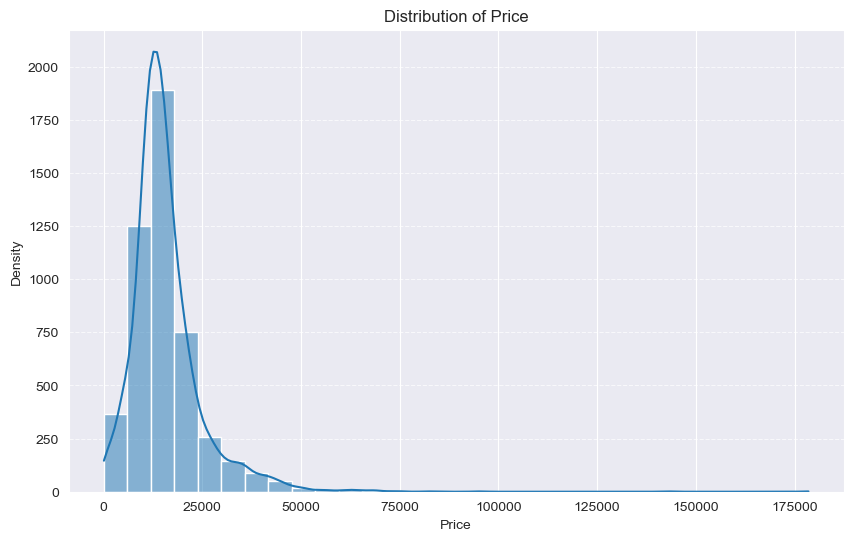

In [7]:
# Plot the probabilistic distribution of the target variable 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2.3. Distribution of numerical variables

Plot the probabilistic distribution of the numerical features.

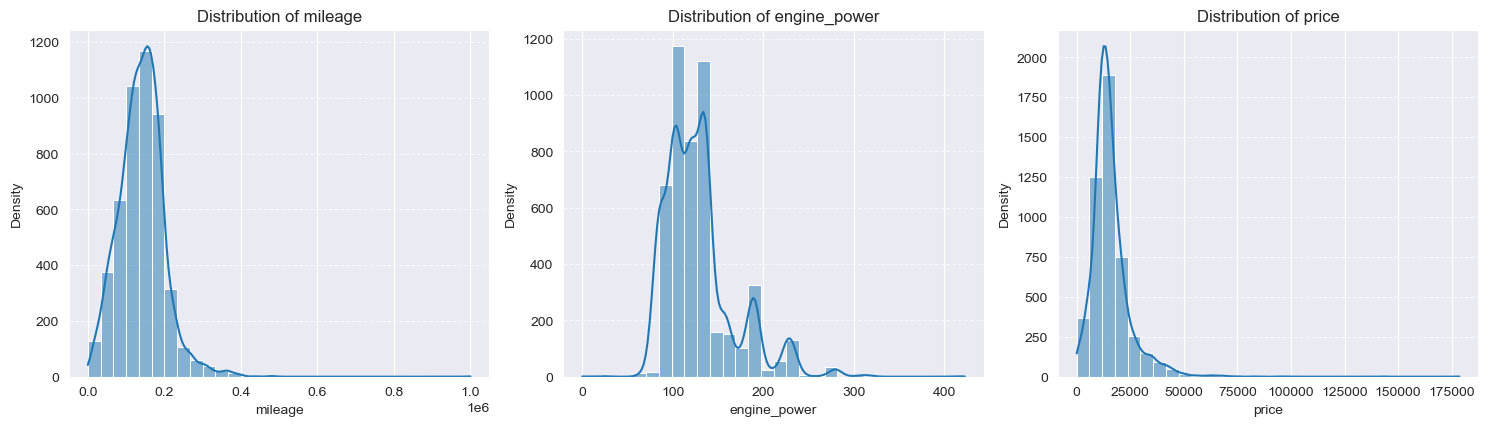

In [8]:
numerical_features = df.select_dtypes(include=['int64']).columns

# Plot the probabilistic distribution of the numerical features
plt.figure(figsize=(15, 12))
for idx, feature in enumerate(numerical_features):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 2.4. Histogram of categorical variables

Plot the histogram of the categorical features.

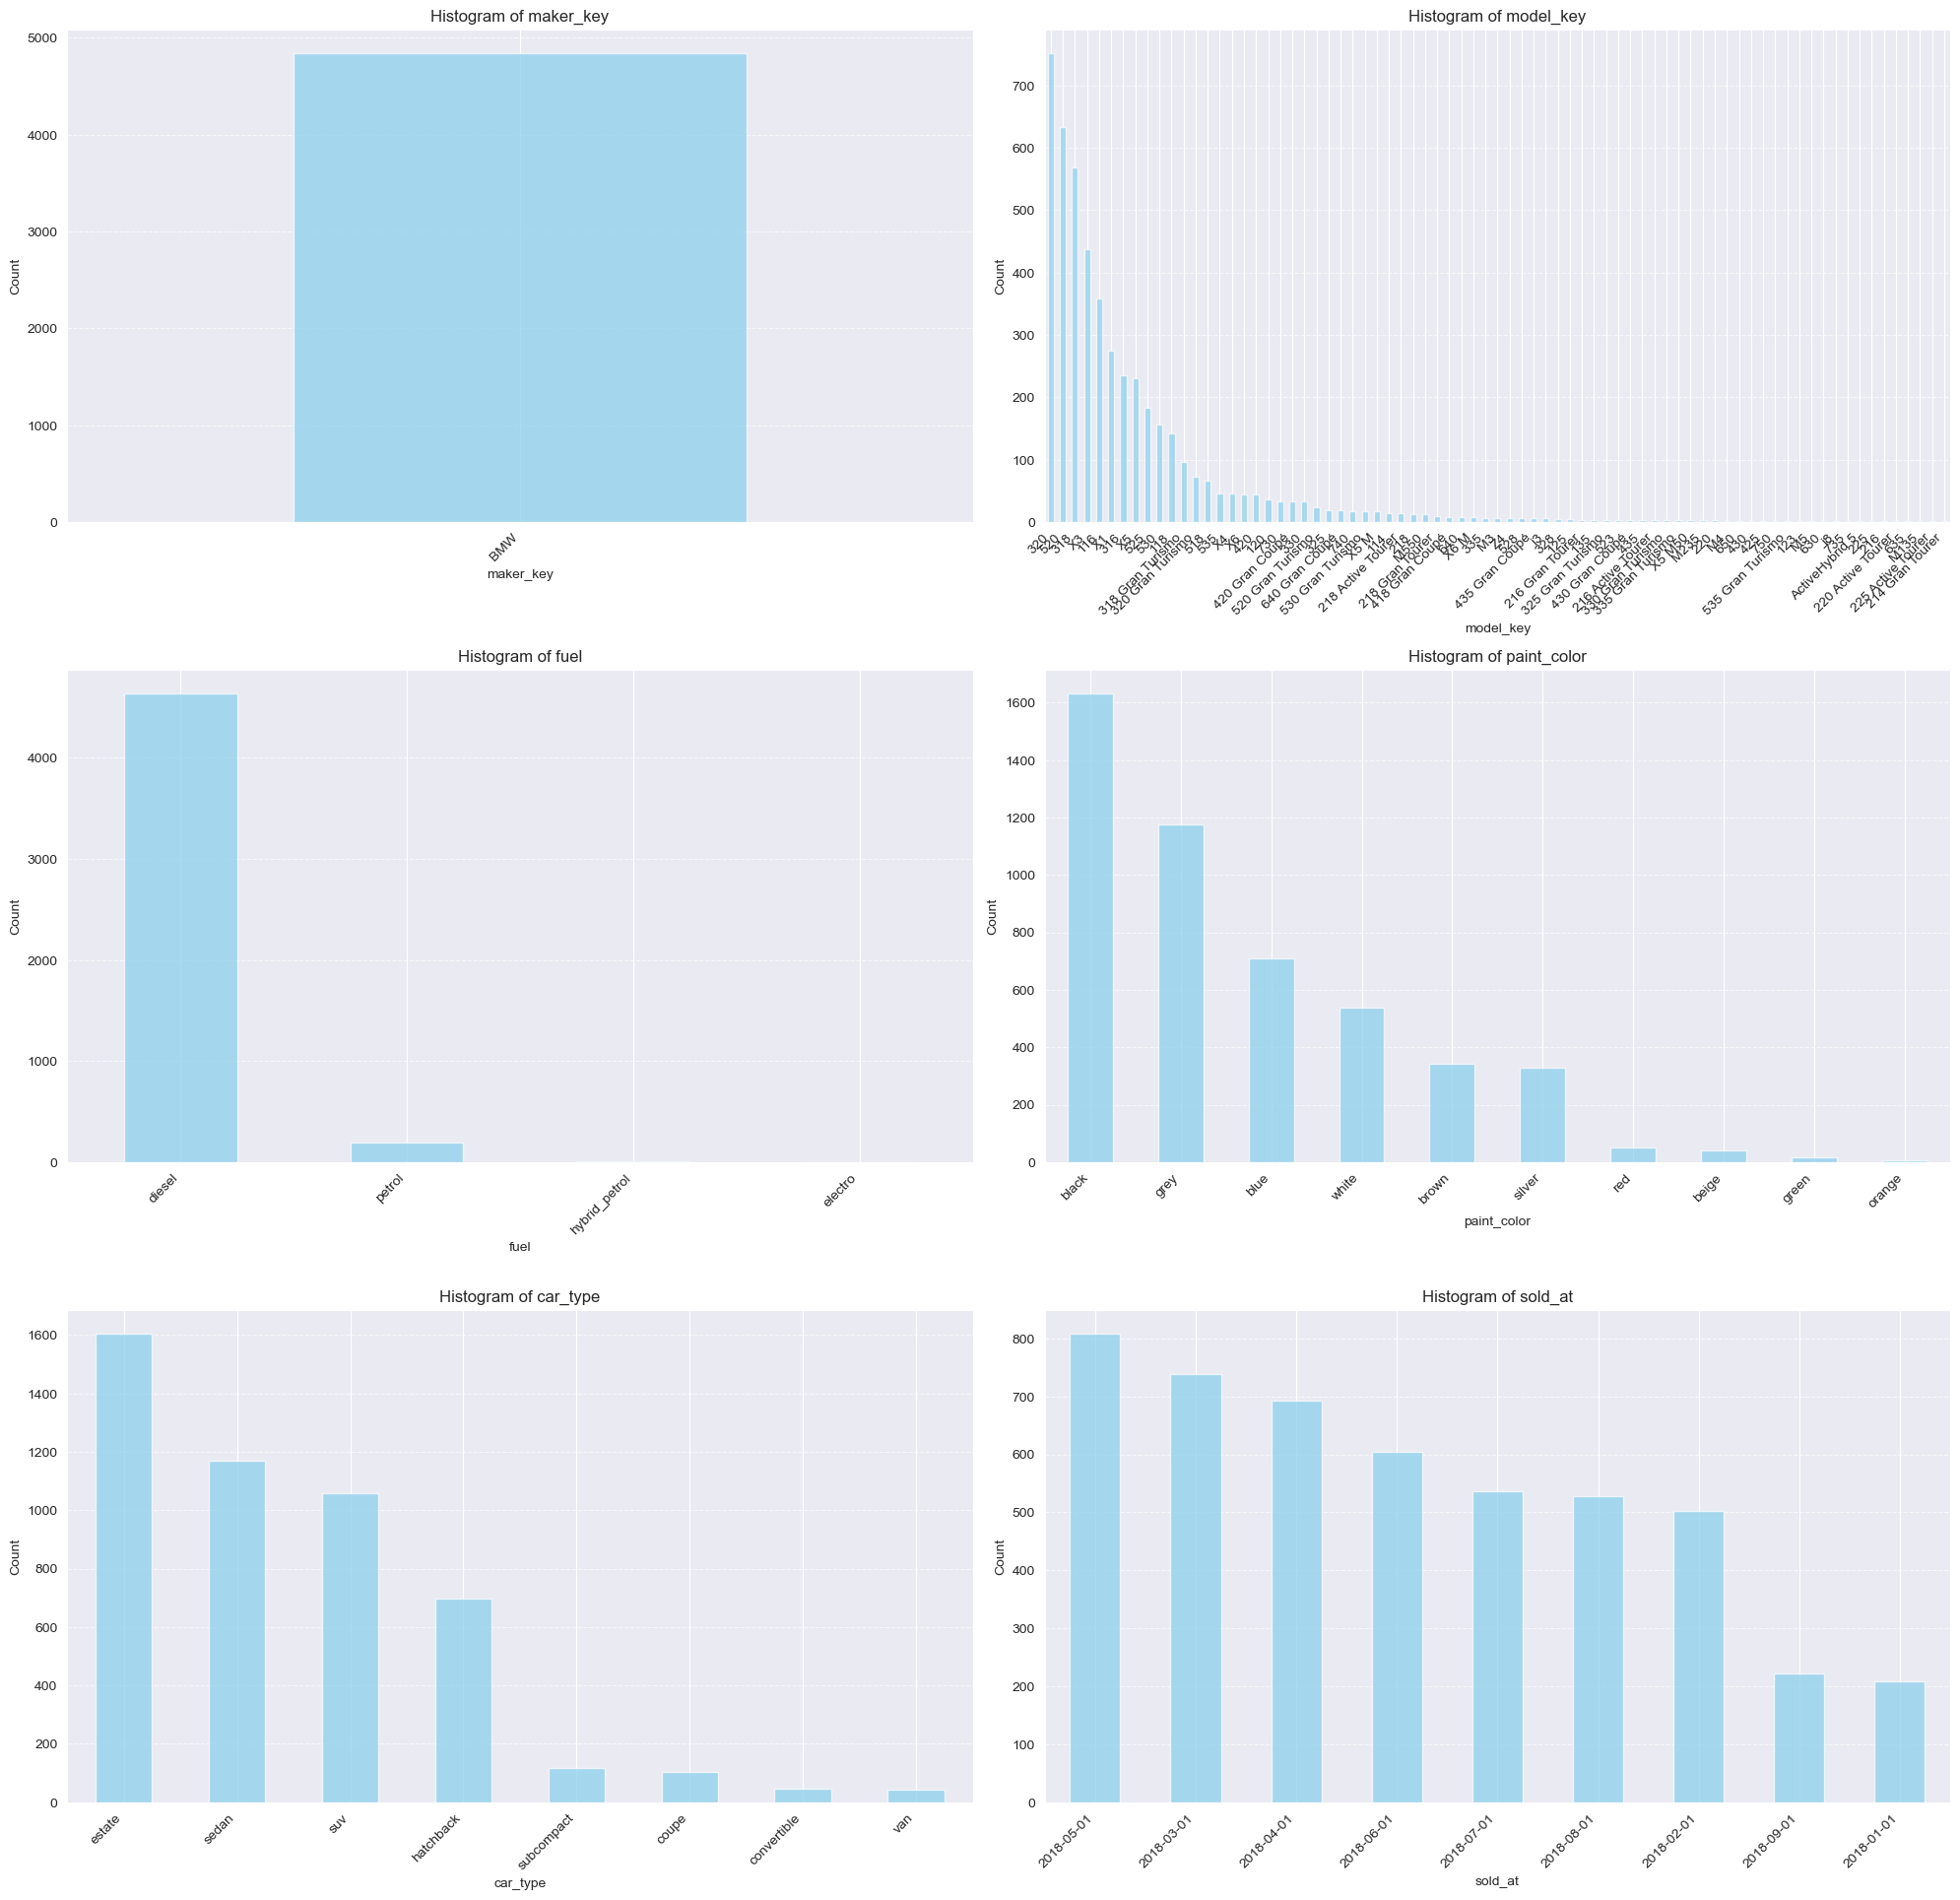

In [9]:
# Selecting only categorical features from the dataset
categorical_features = df.select_dtypes(include=['object']).columns
# Adjusting the histogram plots for categorical features for better readability

# Filtering out 'registration_date' as it doesn't suit categorical plotting in this form
filtered_categorical_features = categorical_features.drop('registration_date')

# Plot the histogram of the categorical features with better visualization
plt.figure(figsize=(20, 25))
for idx, feature in enumerate(filtered_categorical_features):
    plt.subplot(4, 2, idx + 1)
    df[feature].value_counts().plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [10]:
# we have to initiate a variable call ratio that will be used to divide ou data set, like 30/70 ou 20/80
ratio = 0.8

# we just need to shuffle the data before proceeding, and resetting the index
shuffled_df = df.sample(frac=ratio, random_state=42)

# we're getting the ratio
index = int(df.shape[0] * ratio)

# so here we're splitting the data into test and train using our index variable
X_train, X_test = shuffled_df.iloc[:index], df.iloc[index:]

# and we're getting the data used to predict and dropping it from X_train and X_test
y_train, y_test = X_train['price'], X_test['price']
X_train.drop('price', axis=1, inplace=True)
X_test.drop('price', axis=1, inplace=True)

In [11]:
# Just printing the head of the dataframe before shuffling
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [12]:
# Just printing the head of the dataframe before shuffling
shuffled_df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
3203,BMW,520,109839,135,2014-04-01,diesel,black,sedan,True,True,False,False,True,False,True,False,23100,2018-05-01
1957,BMW,318 Gran Turismo,180032,105,2014-03-01,diesel,grey,hatchback,True,True,False,False,False,False,True,False,14300,2018-03-01
1044,BMW,530,147699,190,2013-10-01,diesel,grey,estate,True,True,False,True,True,True,True,True,24900,2018-05-01
2732,BMW,316,95241,85,2012-11-01,diesel,blue,sedan,False,True,False,False,False,False,True,False,12000,2018-02-01
1538,BMW,330,133214,190,2014-03-01,diesel,black,estate,True,True,False,False,True,True,True,True,22000,2018-07-01


## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

We can categorize un necessary features as an id, a string thats not really necessary, in our case the maker since they're all the same

In [13]:
shuffled_df.reset_index(drop=True, inplace=True)
shuffled_df.drop('maker_key', axis=1, inplace=True)
shuffled_df.drop('model_key', axis = 1, inplace=True)

### 4.2. Creating new features

Creating polynomial features for numerical columns

### 4.3. Scaling numerical variables

### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.

### 4.5. Converting boolean columns

## 5. Linear Regression

Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.

## 6. Ridge

Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.

## 7. Lasso

Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.